In [1]:
import os
import numpy as np
import pandas as pd
import glob
import math

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#image imports
import imageio

import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# utils
from IPython.display import clear_output

### Labels used in the process
* Out of 19 only 12 labes or interest are used and defined here

In [2]:
label_to_name = {
    0: "Nucleoplasm",
    1: "Nucleoli",
    2: "Nucleoli fibrillar center",
    3: "Nuclear speckles",
    4: "Nuclear bodies",
    5: "Endoplasmic reticulum",
    6: "Golgi apparatus",
    7: "Intermediate filaments",
    8: "Centrosome",
    9: "Plasma membrane",
    10: "Mitochondria",
    11: "Cytosol"
}

name_label = {
    "Nucleoplasm":0,
    "Nucleoli":1,
    "Nucleoli fibrillar center":2,
    "Nuclear speckles":3,
    "Nuclear bodies":4,
    "Endoplasmic reticulum":5,
    "Golgi apparatus":6,
    "Intermediate filaments":7,
    "Centrosome":8,
    "Plasma membrane":9,
    "Mitochondria":10,
    "Cytosol":11
}

### Constants used for modeling
* Each folder has files for all the 12 classes outlined abouve.
* image size choosen as 512 X 512

In [3]:
IMAGE_SIZE = [512,512]

train_path = 'data/flow/train'
validation_path = 'data/flow/validation'
test_path = 'data/flow/test'
batch_size = 32
label_count = 12

In [4]:
## TBD -- outline how many samples in each class label..

### Geenrators for the train, validation and test
* To train models, keras image generator and images from `labels` directories are used
* Image files are created in the folders such a way that keras `ImageDataGenerator` and `flow_from_directory` utils can be used to read and feed them to neural network

In [5]:
# image generator for train and validation.
# For trainin and test image manipulation parameters are defined as below
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.3,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

# Test generator, feed the images as is
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [6]:
# create generators
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    seed=123
)
valid_generator = gen.flow_from_directory(
    validation_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    seed=456
)

test_gen = test_gen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=batch_size
)

Found 113780 images belonging to 12 classes.
Found 28445 images belonging to 12 classes.
Found 9482 images belonging to 12 classes.


In [27]:
print(test_gen.)

[ 0  0  0 ... 11 11 11]


## Define model

In [7]:
vgg16 = VGG16(
    input_shape=[512, 512, 3], 
    include_top=False, 
    weights=None)
x = Flatten()(vgg16.output)
x = Dense(label_count, activation='softmax')(x)
vgg16_model = Model(vgg16.input, x)
vgg16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Model summary

In [8]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [12]:
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
vgg16_model.compile(loss='categorical_crossentropy', optimizer=opt_adam, metrics=['accuracy'])

## Load saved model

In [13]:
# vgg16 = tf.keras.models.load_model('saved-model/vgg-16-adam/', compile=False)

In [14]:
# opt = tf.keras.optimizers.Adam(learning_rate=0.0000001, amsgrad=True)
# opt = tf.keras.optimizers.Nadam(learning_rate=0.000001,beta_1=0.9, beta_2=0.999)
# vgg16.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Train and validate model

In [15]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
initial_learning_rate = 0.0001
def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 25.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

lr = LearningRateScheduler(lr_step_decay, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1,restore_best_weights=True)
cp = ModelCheckpoint(filepath='saved-model/vgg-16-adam', save_weights_only=False,monitor='val_accuracy', mode='max',save_best_only=True)

In [16]:
result = vgg16_model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=150,
    steps_per_epoch=100,
    validation_steps=20,
    callbacks=[lr,es,cp]
)

C:\Users\sriha\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
100/100 [==============================] - 145s 1s/step - loss: 2.4807 - accuracy: 0.1613 - val_loss: 2.3818 - val_accuracy: 0.1984
INFO:tensorflow:Assets written to: saved-model\vgg-16-adam\assets
Epoch 2/150

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
100/100 [==============================] - 122s 1s/step - loss: 2.4071 - accuracy: 0.1680 - val_loss: 2.4238 - val_accuracy: 0.1656
Epoch 3/150

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0001.
100/100 [==============================] - 122s 1s/step - loss: 2.3995 - accuracy: 0.1771 - val_loss: 2.3386 - val_accuracy: 0.1828
Epoch 4/150

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0001.
100/100 [==============================] - 122s 1s/step - loss: 2.3796 - accuracy: 0.1775 - val_loss: 2.3782 - val_accuracy: 0.1688
Epoch 5/150

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00

## Loss and accuracy visualizations

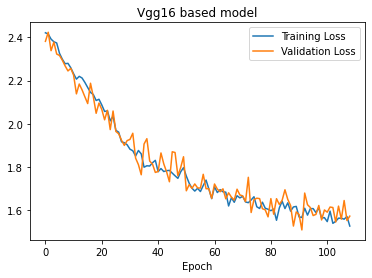

In [17]:
plt.plot(result.history['loss'], label='Training Loss',)
plt.plot(result.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.title('Vgg16 based model')
plt.legend()

### Accuracy

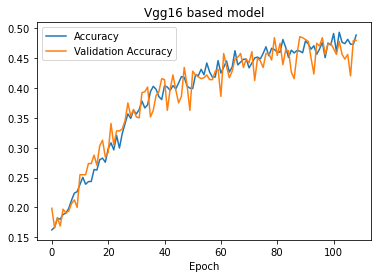

In [18]:
plt.plot(result.history['accuracy'], label='Accuracy')
plt.plot(result.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.title('Vgg16 based model')
plt.legend()

## Test set validation

In [19]:
labels_from_generator = (test_gen.class_indices)
labels_from_generator = [k for k,v in labels_from_generator.items()]
test_gen.reset()
labels_from_generator

['Centrosome',
 'Cytosol',
 'Endoplasmic reticulum',
 'Golgi apparatus',
 'Intermediate filaments',
 'Mitochondria',
 'Nuclear bodies',
 'Nuclear speckles',
 'Nucleoli',
 'Nucleoli fibrillar center',
 'Nucleoplasm',
 'Plasma membrane']

In [20]:
def get_confusion_matrix(model, N):
    # we need to see the data in the same order
    # for both predictions and targets
    print("Generating confusion matrix. Total images to predict", N)
    predictions = []
    targets = []
    i = 0
    for x, y in test_gen:
        i += 1
        if i % 100 == 0:
            print(f'Finished predicting {i} batches')
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break

    cm = confusion_matrix(targets, predictions)
    return cm

In [21]:
%%time
test_gen.reset()
result = get_confusion_matrix( vgg16_model,9482)

Generating confusion matrix. Total images to predict 9482
Finished predicting 100 batches
Finished predicting 200 batches
Wall time: 1min 45s


In [22]:
# print confusion matrix numbers
print(result)

[[ 119   87    0   23    3   21   69    0   10   23  163   52]
 [  34  588   16    9    5   38   18    0    3    1  149  188]
 [   4  273   51    2   14   48    6    0    1    0   70   31]
 [  36   62    0  196    0  127   29   15   17   62  137   57]
 [   7   85   19    8   95  102    4    3    5    5   58   78]
 [  18  181   31   34   21  631    7    6    4    6  183   75]
 [  51   44    0   17    0   14  184   13    3   22  235   16]
 [  15   24    1   25    1   23   19  315    8    8  308    8]
 [  23   27    0   41    0    5   16    7  213   28  101   17]
 [  25   49    0   43    1   10   56   10   14  163   72   13]
 [  25  121    1   10    0   31   33   12    4   10 1397   28]
 [  45  265    2   10    5   36   14    1    3    3   96  519]]


In [23]:
# Normalise to show percentages
cmn = result.astype('float') / result.sum(axis=1)[:, np.newaxis]

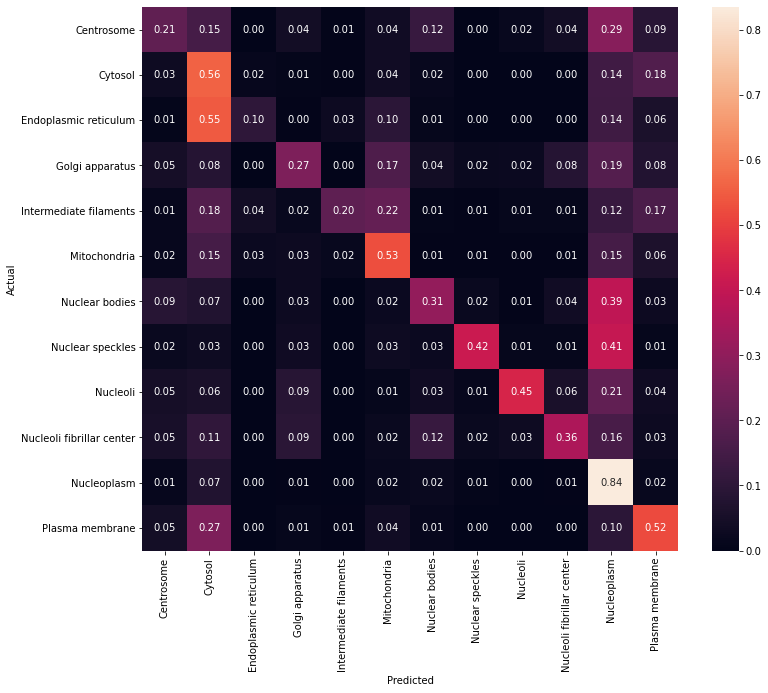

In [24]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels_from_generator, yticklabels=labels_from_generator)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)